<a href="https://colab.research.google.com/github/graphitical/HeadsUP/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [2]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__)

gpu_available = torch.cuda.is_available()
if gpu_available:
  device = 'cuda'
else:
  device = 'cpu'
print('CUDA enabled:', gpu_available)

!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101
CUDA enabled: True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Mount Google Drive

In [5]:
# Use this to mount your google account that has
# access to the shared drive
import os, sys, datetime
from google.colab import drive
drive.mount('/gdrive')

# Change dir to shared drive
BASE_PATH = '/gdrive/Shareddrives/deep learning and PDF accessibility/'
os.chdir(BASE_PATH)
!pwd

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/Shareddrives/deep learning and PDF accessibility


# Load model

## Helper functions

In [6]:
def setup_cfg(config, weights, thresh = 0.5, device = 'cpu'):
    # load config from file and command-line arguments
    cfg = get_cfg()
    cfg.merge_from_file(config)
    # Set score_threshold for builtin models
    cfg.MODEL.WEIGHTS = weights
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = thresh
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresh
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = thresh
    cfg.MODEL.DEVICE = device
    cfg.freeze()
    return cfg

In [7]:
# These are detection class defintions
# Examples are text, title, etc.
# Will need to expand for our training
MetadataCatalog.get("dla_val").thing_classes = ['text','title','list','table','figure']

# BIG MODEL
config = BASE_PATH + 'configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml'
weights = BASE_PATH + 'configs/resnext101.pth'

# LITTLE MODEL
# config = BASE_PATH + 'configs/DLA_mask_rcnn_R_50_FPN_3x.yaml'
# weights = BASE_PATH + 'configs/resnet50.pth'

cfg = setup_cfg(config, weights, device=device)
predictor = DefaultPredictor(cfg)

WARNING [12/14 23:25:24 d2.config.compat]: Config '/gdrive/Shareddrives/deep learning and PDF accessibility/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


# Predict

In [8]:
# Want to loop here, but can hard code for debugging
fname = BASE_PATH + 'images/ASSETS_paper/ASSETS_paper-page-1.png'
im = cv2.imread(fname)
# cv2_imshow(im)
outputs = predictor(im)
# print(type(outputs['instances']))

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


## Visualize

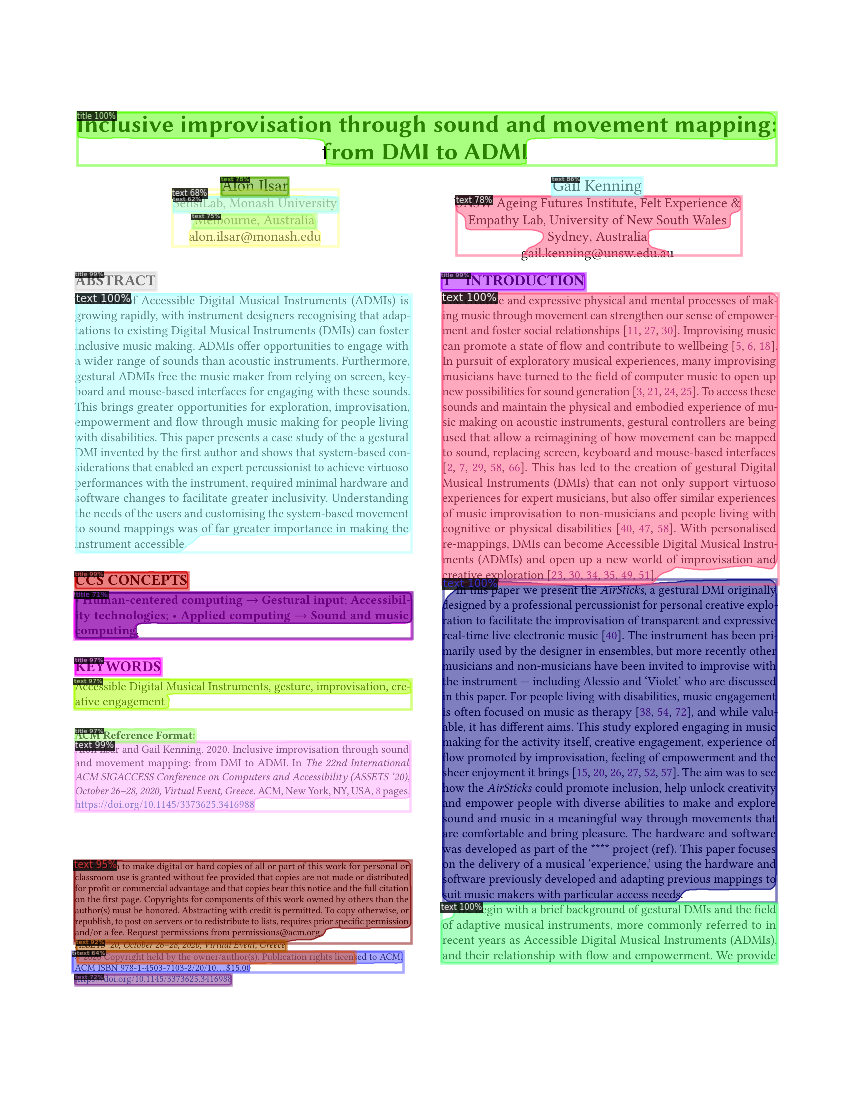

In [9]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("dla_val"), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
print(outputs['instances'])
print()
# print(outputs['instances'].pred_boxes)
# import matplotlib.pyplot as plt
# print(outputs['instances'].pred_masks[0].cpu().numpy())
# plt.imshow(outputs['instances'].pred_masks[0].cpu().numpy())

Instances(num_instances=25, image_height=2200, image_width=1700, fields=[pred_boxes: Boxes(tensor([[ 885.0526, 1158.1091, 1552.7994, 1803.5057],
        [ 884.4844,  585.6922, 1555.2760, 1168.6219],
        [ 151.5337,  587.2892,  821.2396, 1104.8566],
        [ 882.2260, 1805.9578, 1553.9736, 1925.9667],
        [ 154.8795,  223.3707, 1551.1799,  329.4218],
        [ 150.6207,  544.6706,  311.6027,  580.0060],
        [ 882.8649,  546.4799, 1169.7883,  580.0873],
        [ 150.4806, 1482.7781,  820.4676, 1621.7957],
        [ 150.1720, 1143.0869,  375.9620, 1177.4451],
        [ 149.4797, 1316.0665,  321.6097, 1350.1097],
        [ 150.6470, 1457.2043,  389.2528, 1484.2581],
        [ 147.6463, 1357.7472,  822.3192, 1418.2106],
        [ 147.7524, 1720.5453,  821.5641, 1886.1089],
        [ 152.4536, 1880.9209,  572.1400, 1902.3679],
        [ 144.5269, 1902.4952,  805.5001, 1944.1882],
        [1103.0291,  354.5697, 1283.6801,  391.2786],
        [ 441.8999,  354.5528,  576.8441,  39

# Create dataset

## Get pycococreator module

In [24]:
!pip install git+git://github.com/waspinator/pycococreator.git@0.2.0
from pycococreatortools import pycococreatortools as pcc

  Cloning git://github.com/waspinator/pycococreator.git (to revision 0.2.0) to /tmp/pip-req-build-s3_xg96w
  Running command git clone -q git://github.com/waspinator/pycococreator.git /tmp/pip-req-build-s3_xg96w
  Running command git checkout -q fba8f4098f3c7aaa05fe119dc93bbe4063afdab8
  Created wheel for pycococreatortools: filename=pycococreatortools-0.2.0-cp36-none-any.whl size=7191 sha256=f10d3815a508b30ba2ad837c72dad11574c865e47f087c2aafac685fe6d18077
  Stored in directory: /tmp/pip-ephem-wheel-cache-3x38yfbv/wheels/ad/8a/49/9cda5b77c0aec14230df33a9ddfaf60bf488f08a311a2aec0f
Successfully built pycococreatortools


## Dataset Boilerplate Info

In [44]:
INFO = {
    "description": "HeadsUP Dataset",
    "url": "TBD",
    "version": "0.0.0",
    "year": 2020,
    "contibutor": ["graphitical", "venkateshpotluri", "tgotfrid"],
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
  {
      "id": 1,
      "name": "Attribution-NonCommercial-ShareAlike License",
      "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
  }
]

# Will need to update
CATEGORIES = [
  {
      "id": 0,
      "name": "text",
      "supercategory": ""
  },
  {
      "id": 1,
      "name": "title",
      "supercategory": ""
  },
  {
      "id": 2,
      "name": "list",
      "supercategory": ""
  },
  {
      "id": 3,
      "name": "table",
      "supercategory": ""
  },
  {
      "id": 4,
      "name": "figure",
      "supercategory": ""
  }
]

## Dataset Generation

In [45]:
from pathlib import Path

coco_output = {
    'info': INFO, 
    'licenses': LICENSES, 
    'categories': CATEGORIES, 
    'images': [], 
    'annotations': []
}

ann_id = 0
img_id = 0

# dirs to search for image files
DIRS = ['images/ASSETS_paper/']

for DIR in DIRS:
  for image_path in Path(BASE_PATH + DIR).rglob('*.png'):
    image = cv2.imread(str(image_path))
    image_info = pcc.create_image_info(img_id, image_path.name, image.shape)
    coco_output['images'].append(image_info)

    # Predict Output
    pred = predictor(image)

    # Loop over annotations found in image
    boxes, bin_masks, cats = pred['instances'].pred_boxes, pred['instances'].pred_masks, pred['instances'].pred_classes
    for box, mask, cat in zip(boxes, bin_masks, cats):
      cat_info = {'id': cat.item(), 'is_crowd': 0 }
      annotation_info = pcc.create_annotation_info(ann_id, img_id, cat_info, mask.cpu().numpy().astype(int), image.shape[:2], bounding_box=box)
    
      if annotation_info is not None:
        coco_output['annotations'].append(annotation_info)
        ann_id += 1
    img_id += 1

print(coco_output)

{'info': {'description': 'HeadsUP Dataset', 'url': 'TBD', 'version': '0.0.0', 'year': 2020, 'contibutor': ['graphitical', 'venkateshpotluri', 'tgotfrid'], 'date_created': '2020-12-14 23:41:16.624455'}, 'licenses': [{'id': 1, 'name': 'Attribution-NonCommercial-ShareAlike License', 'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/'}], 'categories': [{'id': 0, 'name': 'text', 'supercategory': ''}, {'id': 1, 'name': 'title', 'supercategory': ''}, {'id': 2, 'name': 'list', 'supercategory': ''}, {'id': 3, 'name': 'table', 'supercategory': ''}, {'id': 4, 'name': 'figure', 'supercategory': ''}], 'images': [{'id': 0, 'file_name': 'ASSETS_paper-page-3.png', 'width': 2200, 'height': 1700, 'date_captured': '2020-12-14 23:25:35.725833', 'license': 1, 'coco_url': '', 'flickr_url': ''}, {'id': 1, 'file_name': 'ASSETS_paper-page-8.png', 'width': 2200, 'height': 1700, 'date_captured': '2020-12-14 23:25:35.725833', 'license': 1, 'coco_url': '', 'flickr_url': ''}, {'id': 2, 'file_name': 'ASSETS_p

In [47]:
import json
with open('test.json','w') as fp:
  json.dump(coco_output, fp, indent=4)

# Useful references
1. [Fine tune model](https://github.com/hpanwar08/detectron2/issues/25)
1. [How to make a COCO dataset](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch)
1. [PyCoCoCreator](https://github.com/waspinator/pycococreator)
